<a href="https://colab.research.google.com/github/snowgecko/cxr-notebooks/blob/master/cxr_foundation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

~~~
Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~
<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/cxr-foundation/blob/master/notebooks/quick_start_with_hugging_face.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/google-health/cxr-foundation/blob/master/notebooks/quick_start_with_hugging_face.ipynb">
      <img alt="GitHub logo" src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" width="32px"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://huggingface.co/google/cxr-foundation">
      <img alt="HuggingFace logo" src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="32px"><br> View on HuggingFace
    </a>
  </td>
</tr></tbody></table>

# Quick start with Hugging Face
This Colab notebook provides a basic demo of using Chest X-ray (CXR) Foundation. CXR Foundation is an embeddings models that generates a machine learning representations known as embeddings, from chest X-ray images and/or chest X-ray related text. These embeddings can be used to develop custom models for CXR use-cases with less data and compute compared to traditional model development methods. Learn more about embeddings and their benefits at this [page](https://developers.google.com/health-ai-developer-foundations/cxr-foundation).

In [25]:
# @title Authenticate with HuggingFace, skip if you have a HF_TOKEN secret

# Authenticate user for HuggingFace if needed. Enter token below if requested.
from huggingface_hub.utils import HfFolder
from huggingface_hub import login
import os
hf_token = os.getenv("HF_TOKEN")
login(token=hf_token)
# if HfFolder.get_token() is None:
#     from huggingface_hub import notebook_login
#     notebook_login()

Setup the environment

In [26]:
#!pip install 'numpy>=1.22,<1.26'
!pip install -U "tensorflow==2.19.0" "tensorflow-text==2.19.*" tensorflow-hub pypng

In [27]:
# @title Helper Functions to prepare inputs: text & image TF Example
#!pip install tensorflow-text==2.17 pypng 2>&1 1>/dev/null
import io
import png
import tensorflow as tf
import tensorflow_text as tf_text
import tensorflow_hub as tf_hub
import numpy as np


# Helper function for tokenizing text input
#"/well/papiez/users/hri611/python/foundation-models-radiology/models/tensorflow/bert/tensorFlow2/en-uncased-preprocess/3"
# one for text (BERT tokens + paddings)
def bert_tokenize(text):
    """Tokenizes input text and returns token IDs and padding masks."""
    preprocessor = tf_hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    out = preprocessor(tf.constant([text.lower()]))
    ids = out['input_word_ids'].numpy().astype(np.int32)
    masks = out['input_mask'].numpy().astype(np.float32)
    paddings = 1.0 - masks
    end_token_idx = ids == 102
    ids[end_token_idx] = 0
    paddings[end_token_idx] = 1.0
    ids = np.expand_dims(ids, axis=1)
    paddings = np.expand_dims(paddings, axis=1)
    assert ids.shape == (1, 1, 128)
    assert paddings.shape == (1, 1, 128)
    return ids, paddings

# Helper function for processing image data - image (encode a 2-D array as PNG bytes inside a TensorFlow Example).
def png_to_tfexample(image_array: np.ndarray) -> tf.train.Example:
    """Creates a tf.train.Example from a NumPy array."""
    # Convert the image to float32 and shift the minimum value to zero
    image = image_array.astype(np.float32)
    image -= image.min()

    if image_array.dtype == np.uint8:
        # For uint8 images, no rescaling is needed
        pixel_array = image.astype(np.uint8)
        bitdepth = 8
    else:
        # For other data types, scale image to use the full 16-bit range
        max_val = image.max()
        if max_val > 0:
            image *= 65535 / max_val  # Scale to 16-bit range
        pixel_array = image.astype(np.uint16)
        bitdepth = 16

    # Ensure the array is 2-D (grayscale image)
    if pixel_array.ndim != 2:
        raise ValueError(f'Array must be 2-D. Actual dimensions: {pixel_array.ndim}')

    # Encode the array as a PNG image
    output = io.BytesIO()
    png.Writer(
        width=pixel_array.shape[1],
        height=pixel_array.shape[0],
        greyscale=True,
        bitdepth=bitdepth
    ).write(output, pixel_array.tolist())
    png_bytes = output.getvalue()

    # Create a tf.train.Example and assign the features
    example = tf.train.Example()
    features = example.features.feature
    features['image/encoded'].bytes_list.value.append(png_bytes)
    features['image/format'].bytes_list.value.append(b'png')

    return example

In [28]:
!pip install pydicom
import pydicom

def dicom_to_tfexample(dicom_path: str) -> tf.train.Example:
    """Reads a DICOM image and converts it into a tf.train.Example."""

    # Load DICOM file
    dcm = pydicom.dcmread(dicom_path)
    image_array = dcm.pixel_array.astype(np.float32)

    # Normalize the image (shift min to 0)
    image_array -= image_array.min()

    # Determine bit depth
    max_val = image_array.max()
    if dcm.BitsStored == 8 or max_val <= 255:
        pixel_array = image_array.astype(np.uint8)
        bitdepth = 8
    else:
        if max_val > 0:
            image_array *= 65535 / max_val  # Scale to 16-bit range
        pixel_array = image_array.astype(np.uint16)
        bitdepth = 16

    # Encode the array as a PNG image
    output = io.BytesIO()
    png.Writer(
        width=pixel_array.shape[1],
        height=pixel_array.shape[0],
        greyscale=True,
        bitdepth=bitdepth
    ).write(output, pixel_array.tolist())
    png_bytes = output.getvalue()

    # Create a tf.train.Example and assign the features
    example = tf.train.Example()
    features = example.features.feature
    features['image/encoded'].bytes_list.value.append(png_bytes)
    features['image/format'].bytes_list.value.append(b'png')

    return example

# Generate embeddings from dicom images

In [29]:
# attach the colab project to teh files
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:

from pathlib import Path
root_dir = Path('/content/drive/MyDrive/MLProjects/foundation-models-radiology')
data_dir = root_dir / 'PTXHeadtoHeadSmall'   # use the exact folder name as on Drive
print("exists:", data_dir.exists())

# find DICOMs (case-insensitive .dcm)
dicom_paths = list(data_dir.rglob('*.[dD][cC][mM]'))
print("count:", len(dicom_paths))
print("samples:", dicom_paths[:5])


exists: True
count: 2
samples: [PosixPath('/content/drive/MyDrive/MLProjects/foundation-models-radiology/PTXHeadtoHeadSmall/0a1d53cc79cb2ee50afa507d425f6d15/04797ae93ba9e94174bd928999395887/204611bfbd3e2c990bc2e9d6e131d46a/813f8b5f7031f381d6aadb2edcdd15cf.dcm'), PosixPath('/content/drive/MyDrive/MLProjects/foundation-models-radiology/PTXHeadtoHeadSmall/ffac9214400053aa4c78126255328235/113cd0ccb7393ecb0a5a8a94dac38f72/73cedef0efa5a294616db1be804bd026/3dc870d5ffa18cb81c81342ca478eb4f.dcm')]


In [12]:
# load images (first drag into folder)
import glob
from pathlib import Path


#root_dir = Path('/users/default/MLProjects/foundation-models-radiology')

# Find all DICOM files under folders like 017positive/*/*/*/*.dcm and 017negative/*/*/*/*.dcm
# dicom_paths = glob.glob(str(root_dir / 'pnx'/ '017Positive/**/*.dcm'), recursive=True)
# dicom_paths += glob.glob(str(root_dir / 'pnx' / '017Negative/**/*.dcm'), recursive=True)

#dicom_paths = glob.glob(str(root_dir / 'PTX Head to Head Study Data' / '**/*.dcm'), recursive=True)



In [31]:
# @title Download model
import numpy as np
import matplotlib.pyplot as plt
import os
from huggingface_hub import snapshot_download

#root_dir = '/users/default/MLProjects/foundation-models-radiology' now using root_dir from mouted Drive
snapshot_download(repo_id="google/cxr-foundation",local_dir=os.path.join(root_dir,'hf'),
                  allow_patterns=['elixr-c-v2-pooled/*', 'pax-elixr-b-text/*']) # instead of /content/hf

if 'elixrc_model' not in locals():
  elixrc_model = tf.saved_model.load(os.path.join(root_dir,'hf','elixr-c-v2-pooled'))
  elixrc_infer = elixrc_model.signatures['serving_default']

if 'qformer_model' not in locals():
  qformer_model = tf.saved_model.load(os.path.join(root_dir,'hf','pax-elixr-b-text'))

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

In [32]:
# @title Generate image embeddings
import pandas as pd
import tqdm
# import numpy as np

# image_paths = list of image dcm paths - could also try to get true label
# image_paths = ['/users/default/MLProjects/foundation-models-radiology/PTX Head to Head Study Data/pnx/017Negative/0c7c4bcaed8045da28007d3f5ad951b4/f9e703569f6b7cb2aecd350011688045/1fe308bc6e36a342e2a3693f37729c44/2490b1fb93d7c4700058df540fd60532.dcm','/well/papiez/users/hri611/python/foundation-models-radiology/pnx/017Positive/0d5bb46d8471b59a17517f7dfc22267d/95b02f3d3b4e867c40ec7e29dde6368e/d5b1bbc1340808d610ec61d97b4ddd4c/25a630ebeedc7f250ca2cc3e4693612d.dcm']
image_paths = dicom_paths
list_of_elixrb_embeddings = []

for image_path in tqdm.tqdm(image_paths, desc="Processing images"):
  serialized_dicom_tf_example = dicom_to_tfexample(image_path).SerializeToString()

  # Step 1 - ELIXR C (image to elixr C embeddings)

  elixrc_output = elixrc_infer(input_example=tf.constant([serialized_dicom_tf_example]))
  elixrc_embedding = elixrc_output['feature_maps_0'].numpy()

  # Step 2 - Invoke QFormer with Elixr-C embeddings
  # Initialize text inputs with zeros
  qformer_input = {
      'image_feature': elixrc_embedding.tolist(),
      'ids': np.zeros((1, 1, 128), dtype=np.int32).tolist(),
      'paddings':np.zeros((1, 1, 128), dtype=np.float32).tolist(),
  }

  qformer_output = qformer_model.signatures['serving_default'](**qformer_input)
  elixrb_embeddings = qformer_output['all_contrastive_img_emb']

  list_of_elixrb_embeddings.append(elixrb_embeddings)

image_embeddings_df = pd.DataFrame()
image_embeddings_df['image_paths'] = image_paths
image_embeddings_df['elixrb_embeddings'] = list_of_elixrb_embeddings
# image_embeddings_df.to_csv('image_embeddings.csv', index=False)

Processing images: 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]


In [33]:
# @title Generate text embeddings
snapshot_download(repo_id="google/cxr-foundation",local_dir=os.path.join(root_dir,'hf'),
                  allow_patterns=['elixr-c-v2-pooled/*', 'pax-elixr-b-text/*'])

# Run QFormer with text only.
# Initialize image input with zeros
tokens, paddings = bert_tokenize("No pneumothorax")
qformer_input = {
    'image_feature': np.zeros([1, 8, 8, 1376], dtype=np.float32).tolist(),
    'ids': tokens.tolist(),
    'paddings': paddings.tolist(),
}

if 'qformer_model' not in locals():
  qformer_model = tf.saved_model.load(os.path.join('hf/pax-elixr-b-text'))

qformer_output = qformer_model.signatures['serving_default'](**qformer_input)
negative_text_embedding = qformer_output['contrastive_txt_emb']

# tokens, paddings = bert_tokenize("Small pneumothorax")
tokens, paddings = bert_tokenize("Pneumothorax")

qformer_input = {
    'image_feature': np.zeros([1, 8, 8, 1376], dtype=np.float32).tolist(),
    'ids': tokens.tolist(),
    'paddings': paddings.tolist(),
}

if 'qformer_model' not in locals():
  qformer_model = tf.saved_model.load("/content/hf/pax-elixr-b-text")

qformer_output = qformer_model.signatures['serving_default'](**qformer_input)
positive_text_embedding = qformer_output['contrastive_txt_emb']

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

In [34]:
# @title Helper functions to get similarity score

def compute_image_text_similarity(image_emb, txt_emb):
  image_emb = np.reshape(image_emb, (32, 128))
  similarities = []
  for i in range(32):
    # cosine similarity
    similarity = np.dot(image_emb[i], txt_emb)/(np.linalg.norm(image_emb[i]) * np.linalg.norm(txt_emb))
    similarities.append(similarity)
  np_sm_similarities = np.array((similarities))
  return np.max(np_sm_similarities)

def zero_shot(image_emb, pos_txt_emb,neg_txt_emb):
  pos_cosine = compute_image_text_similarity(image_emb, pos_txt_emb)
  neg_cosine = compute_image_text_similarity(image_emb, neg_txt_emb)
  return pos_cosine - neg_cosine


In [35]:
# Iterate over each image_id in eval_data_df
for index, row in image_embeddings_df.iterrows():
  image_id = row['image_paths']
  # Get the embedding for the current image_id from image_embeddings_df
  image_embedding = image_embeddings_df[image_embeddings_df['image_paths'] == image_id]['elixrb_embeddings'].iloc[0]
  # Compute the similarity using the zero_shot function
  similarity_score = zero_shot(image_embedding, positive_text_embedding[0], negative_text_embedding[0])
  # Store the similarity score in a new column named 'score'
  image_embeddings_df.loc[index, 'score'] = similarity_score
  image_embeddings_df.to_csv('ptx_image_embeddings_with_scores.csv', index=False)

0 2


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.47431421, 0.47621101, 0.47810781, 0.48000461, 0.48190141,
        0.48379821, 0.48569503, 0.48759183, 0.48948863, 0.49138543,
        0.49328223]),
 <BarContainer object of 10 artists>)

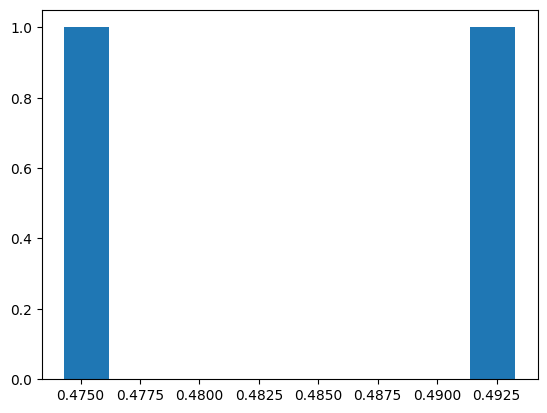

In [36]:
#data_dir = root_dir / 'PTXHeadtoHeadSmall'   # use the exact folder name as on Drive
#final_df = pd.DataFrame()
#final_df['image_paths'] = image_embeddings_df['image_paths'].apply(lambda x: x.replace((str(data_dir)+'/'), ''))
#final_df['score'] = image_embeddings_df['score']/2+0.5
#final_df['binary_score'] = final_df['score'].apply(lambda x: 1 if x >= 0.5 else 0)

data_dir = Path(data_dir)  # <-- set yours
def to_rel(p, base=data_dir):
    p = Path(p)
    try:
        return p.resolve().relative_to(base.resolve()).as_posix()
    except Exception:
        return p.name  # fallback if not under base

final_df = pd.DataFrame()
final_df["image_paths"] = image_embeddings_df["image_paths"].map(to_rel)
final_df["score"] = image_embeddings_df["score"]/2 + 0.5
final_df["binary_score"] = final_df['score'].apply(lambda x: 1 if x >= 0.5 else 0)


print(len(final_df[final_df['binary_score'] == 1]), len(final_df[final_df['binary_score'] == 0]))
plt.hist(final_df['score'])



In [37]:
final_df.to_csv('ptx_google_scores.csv', index=False)

In [38]:
microsoft_df = pd.read_csv('ptx_biomedclip_scores.csv')
google_df = pd.read_csv('ptx_google_scores.csv')

merged_df = pd.merge(microsoft_df, google_df, on='image_paths', suffixes=('_microsoft', '_google'))


FileNotFoundError: [Errno 2] No such file or directory: 'ptx_biomedclip_scores.csv'

In [ ]:
merged_df.to_csv('ptx_google_micrsoft_scores.csv', index=False)

In [ ]:
merged_df[['binary_score_google','binary_score_microsoft']].value_counts()

binary_score_google  binary_score_microsoft
0                    0                         249
                     1                          98
1                    0                          47
                     1                          19
Name: count, dtype: int64

In [ ]:
merged_df[merged_df['binary_score_google']==1&(merged_df['binary_score_microsoft']==1)].shape[0]

268

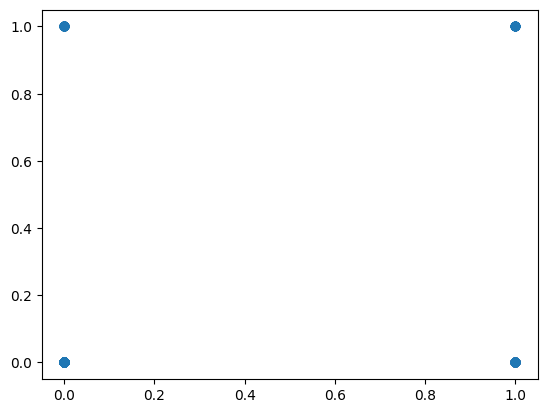

In [ ]:
plt.scatter(merged_df['binary_score_microsoft'], merged_df['binary_score_google'])

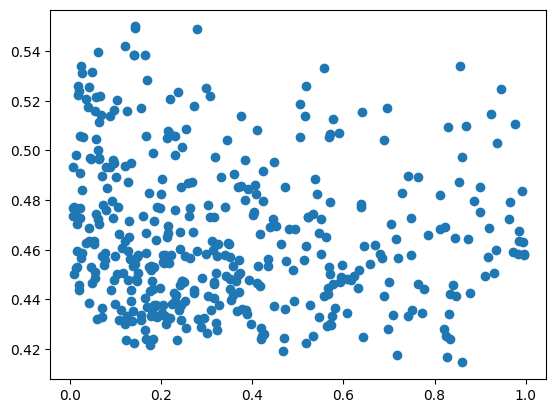

In [ ]:
plt.scatter(merged_df['score_microsoft'], merged_df['score_google'])